# CIFAR-10

This notebook contains our experiements comparing forward gradient and backpropagation for Convolutional nets on the CIFAR-10 dataset

#### Setup

In [1]:
# Run once
# CPU only: !pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0 -f https://download.pytorch.org/whl/cpu/torch_stable.html
!pip install --pre torch -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html --upgrade
!pip install functorch
print("--> Restarting colab instance") 
get_ipython().kernel.do_shutdown(True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html
     |████████████████████████████████| 190.8 MB 81 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.13.0.dev20220613+cpu which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.13.0.dev20220613+cpu which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.13.0.dev20220613+cpu which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/

{'restart': True, 'status': 'ok'}

In [1]:
!git clone https://github.com/benjaminrike1/forward_gradient

Cloning into 'forward_gradient'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 115 (delta 56), reused 78 (delta 30), pack-reused 0
Receiving objects: 100% (115/115), 2.04 MiB | 27.82 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [2]:
cd forward_gradient

/content/forward_gradient


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import functorch as ft

import numpy as np
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns

from loss import functional_xent, softmax, clamp_probs, _xent
from optimizers import ForwardSGD, ForwardAdam
from models import Net, ConvNet, CifarNet

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## CIFAR dataset

Importing the data from torchvision.

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])


cifar_train = torchvision.datasets.CIFAR10(
    '/tmp/data',
    train=True, 
    download=True, 
    transform=transform
)
# splitting into training and validation set
train, val = torch.utils.data.random_split(cifar_train, [40000, 10000])

train_data_loader = torch.utils.data.DataLoader(train, 
                                          batch_size=64, 
                                          shuffle=True)

val_data_loader = torch.utils.data.DataLoader(val, 
                                          batch_size=64, 
                                          shuffle=True)

mnist_test = torchvision.datasets.CIFAR10(
    '/tmp/data',
    train=False, 
    download=True, 
    transform=transform
)
test_data_loader = torch.utils.data.DataLoader(mnist_test, 
                                              batch_size=64,
                                              shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /tmp/data/cifar-10-python.tar.gz to /tmp/data
Files already downloaded and verified


# Convolutional Neural Network

We use a CNN for the modeling. The CNN follows the VGG architecture, but do only have three blocks and two fully connected layers whereas VGG has five blocks and three fully connected layers, Code can be found in `models.py` and information about the model in `report.pdf`.

## SGD

### Learning rate optimization

The final search for learning rate is in a quite small interval as we earlier tried a wider search, but wanted to reduce the width to find a better optimum.

Searching for best learning rate and learning rate decay for forward gradient.

In [ ]:
torch.manual_seed(42) # setting seed for reproducibility

# learning rate and decays grid search for forward gradient
learning_rates = np.logspace(-7, -2, 12)
decays = [1e-6]

epochs = 20

for gamma in learning_rates:
  for lambda_ in decays:
    net = CifarNet().to(device) # defining net

    # making the net functional to run the code in functorch
    # for evaluating the Jacobian-vector product
    func, params = ft.make_functional(net)

    # removing requires gradient as it will not be used
    # for the forward AD
    for param in params:
        param.requires_grad_(False)

    # defining our optimizer
    opt = ForwardSGD(func, functional_xent, params, lr=gamma, momentum = False, decay=lambda_)

    # training
    for e in range(epochs):
      for i, (image, label) in enumerate(train_data_loader):
        image, label = image.to(device), label.to(device)
        params, loss, jvp = opt.step(image, label) # one optimization step

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = functional_xent(params, func,image, label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, decay = {format(lambda_,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.000000, decay = 0.000001: 2.303
Validation loss for lr = 0.000000, decay = 0.000001: 2.303
Validation loss for lr = 0.000001, decay = 0.000001: 2.303
Validation loss for lr = 0.000002, decay = 0.000001: 2.303
Validation loss for lr = 0.000007, decay = 0.000001: 2.303
Validation loss for lr = 0.000019, decay = 0.000001: 2.303
Validation loss for lr = 0.000053, decay = 0.000001: 2.303
Validation loss for lr = 0.000152, decay = 0.000001: 2.303
Validation loss for lr = 0.000433, decay = 0.000001: 2.302
Validation loss for lr = 0.001233, decay = 0.000001: 14.380
Validation loss for lr = 0.003511, decay = 0.000001: 14.394
Validation loss for lr = 0.010000, decay = 0.000001: 14.354


Searching for best learning rate and learning rate decay for backpropagation.

In [6]:
torch.manual_seed(42) # setting seed for reporducibility

# defining learning rates and decays for grid search
learning_rates = np.logspace(-4, -2, 4)
decays = [1e-4]
epochs = 20
criterion = nn.CrossEntropyLoss() # loss function
for gamma in learning_rates:
  for lambda_ in decays:
    lr_new = gamma
    net = CifarNet().to(device) # defining net

    # storing losses
    losses = []
    steps = 0
    for epoch in range(epochs):
      # going over training set in batches
      for i, (image, label) in enumerate(train_data_loader):
        steps += 1
        backprop = torch.optim.SGD(net.parameters(), lr=lr_new) # backprop SGD
        image, label = image.to(device), label.to(device)

        # optimizing
        backprop.zero_grad()
        outputs = net(image)
        loss = criterion(outputs, label)
        loss.backward()
        backprop.step()
        losses.append(loss.item())

        # learning rate decay
        lr_new = gamma * np.exp(-steps*lambda_)

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = criterion(net(image), label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, decay = {format(lambda_,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.000100, decay = 0.000001: 2.303
Validation loss for lr = 0.000464, decay = 0.000001: 2.302
Validation loss for lr = 0.002154, decay = 0.000001: 2.300
Validation loss for lr = 0.010000, decay = 0.000001: 1.260


### Modeling

We first run forward gradient for the optimal hyperparameters.

In [11]:
torch.manual_seed(42) # setting seed for reproducibility

net = CifarNet().to(device) # defining net

# using best lr and decay found in the optimizations below
lr = 0.000433
decay = 1e-6
# making the net functional to run the code in functorch
# for evaluating the Jacobian-vector product
func, params = ft.make_functional(net)

# removing requires gradient as it will not be used
# for the forward AD
for param in params:
    param.requires_grad_(False)

# defining our optimizer
opt = ForwardSGD(func, functional_xent, params, lr=lr, momentum = False, decay=decay, clip = 1)

# training for e epochs
losses_fwd = []
norms = []
epochs = 100
test_losses_fwd = []
for e in range(epochs):
  for j, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    params, loss, norm = opt.step(image, label)
    try:
      norms.append(norm.item())
    except:
      norms.append(norm)
    losses_fwd.append(loss.item())

  # evaluating on the test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = functional_xent(params, func, image, label)
      batch_loss.append(test_loss.item())
  test_losses_fwd.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {format(test_losses_fwd[-1], '.3f')}")


Test loss in epoch 1: 2.302
Test loss in epoch 2: 2.299
Test loss in epoch 3: 2.299
Test loss in epoch 4: 2.300
Test loss in epoch 5: 2.301
Test loss in epoch 6: 2.300
Test loss in epoch 7: 2.304
Test loss in epoch 8: 2.307
Test loss in epoch 9: 2.300
Test loss in epoch 10: 2.303
Test loss in epoch 11: 2.307
Test loss in epoch 12: 2.304
Test loss in epoch 13: 2.308
Test loss in epoch 14: 2.302
Test loss in epoch 15: 2.303
Test loss in epoch 16: 2.302
Test loss in epoch 17: 2.304
Test loss in epoch 18: 2.304
Test loss in epoch 19: 2.308
Test loss in epoch 20: 2.301
Test loss in epoch 21: 2.301
Test loss in epoch 22: 2.304
Test loss in epoch 23: 2.302
Test loss in epoch 24: 2.305
Test loss in epoch 25: 2.302
Test loss in epoch 26: 2.300
Test loss in epoch 27: 2.305
Test loss in epoch 28: 2.303
Test loss in epoch 29: 2.300
Test loss in epoch 30: 2.299
Test loss in epoch 31: 2.304
Test loss in epoch 32: 2.301
Test loss in epoch 33: 2.302
Test loss in epoch 34: 2.298
Test loss in epoch 35: 

Backpropagation:

In [12]:
torch.manual_seed(42) # setting seed for reproducibility

lr = 1e-2
decay = 1e-4
epochs = 100
lr_new = lr
criterion = nn.CrossEntropyLoss() # loss function
net = CifarNet().to(device) # defining net

# storing losses
losses = []
test_losses = []
steps = 0
for e in range(epochs):
  # going over training set in batches
  for i, (image, label) in enumerate(train_data_loader):
    steps += 1
    backprop = torch.optim.SGD(net.parameters(), lr=lr_new) # normal SGD in torch
    image, label = image.to(device), label.to(device)
    backprop.zero_grad()
    outputs = net(image)
    loss = criterion(outputs, label)
    loss.backward()
    backprop.step()
    losses.append(loss.item())
    lr_new = lr * np.exp(-steps*decay)
  
  # testing on test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = criterion(net(image), label)
      batch_loss.append(test_loss.item())
  test_losses.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses[-1])}")

Test loss in epoch 1: 2.3031558990478516
Test loss in epoch 2: 2.300645589828491
Test loss in epoch 3: 2.3015296459198
Test loss in epoch 4: 2.3002700805664062
Test loss in epoch 5: 2.299867868423462
Test loss in epoch 6: 2.2971816062927246
Test loss in epoch 7: 2.2986018657684326
Test loss in epoch 8: 2.274179697036743
Test loss in epoch 9: 2.126858711242676
Test loss in epoch 10: 1.8456233739852905
Test loss in epoch 11: 1.8201780319213867
Test loss in epoch 12: 1.5900312662124634
Test loss in epoch 13: 1.5695379972457886
Test loss in epoch 14: 1.253920555114746
Test loss in epoch 15: 1.461121916770935
Test loss in epoch 16: 1.532792329788208
Test loss in epoch 17: 1.4207061529159546
Test loss in epoch 18: 1.8584564924240112
Test loss in epoch 19: 1.3575530052185059
Test loss in epoch 20: 1.7688192129135132
Test loss in epoch 21: 1.678882122039795
Test loss in epoch 22: 1.7847189903259277
Test loss in epoch 23: 1.1862244606018066
Test loss in epoch 24: 1.4104552268981934
Test loss in

#### Comparing results

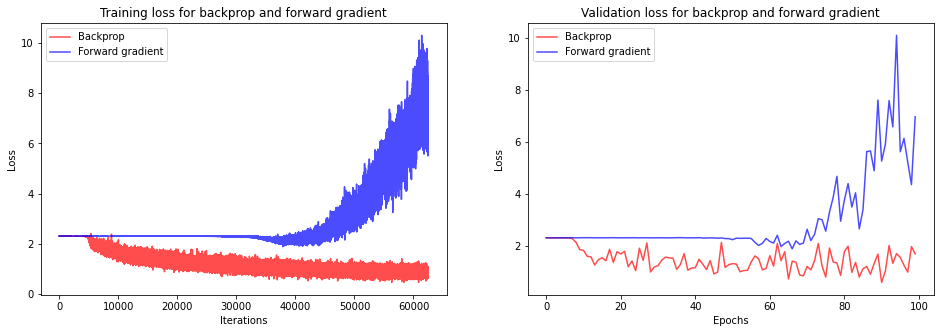

In [15]:
fig, ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses, color='r', label="Backprop", alpha=.7)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[0].plot(losses_fwd[:], color='b', label='Forward gradient', alpha=.7)
ax[0].set_title("Training loss for backprop and forward gradient")
ax[0].legend()

ax[1].plot(test_losses, color='r', label="Backprop", alpha=.7)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].plot(test_losses_fwd, color='b', label='Forward gradient', alpha=.7)
ax[1].set_title("Validation loss for backprop and forward gradient")
ax[1].legend()

As we see, the forward gradient struggles to learn at all before the loss suddenly explodes upwards. Therefore, we don't attempt the other optimization algorithms at the CIFAR dataset.